# Constructing and fitting models

The [astropy.modeling](http://docs.astropy.org/en/stable/modeling/index.html) sub-package provides a convenient interface for defining and fitting models. There are of course a number of other packages in Python for fitting/optimization, such as [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) and [lmfit](https://lmfit.github.io/lmfit-py/), but astropy.modeling provides simple to use pre-defined models as well as a common interface for different fitting algorithms. In addition, it simplifies the task of fitting models to multi-dimensional data.


<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span> Objectives</h2>
</div>


<div class="panel-body">

<ul>
<li>Use built-in 1D and 2D models</li>
<li>Fit 1D and 2D data</li>
<li>Extracting information about the fit</li>
<li>Defining compound models</li>
<li>Working with unitful quantities</li>
</ul>

</div>

</section>


## Documentation

This notebook only shows a subset of the functionality in astropy.modeling. For more information about the features presented below as well as other available features, you can read the
[astropy.modeling documentation](https://docs.astropy.org/en/stable/modeling/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

## Using built-in models

The astropy.modeling sub-package includes a number of built-in models, which can be accessed from the astropy.modeling.models module:

In [2]:
from astropy.modeling import models

In [3]:
models.Gaussian1D

<class 'astropy.modeling.functional_models.Gaussian1D'>
Name: Gaussian1D
N_inputs: 1
N_outputs: 1
Fittable parameters: ('amplitude', 'mean', 'stddev')

Once you create a model, you can think of it as a parameterized function:

In [4]:
g = models.Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)
g

<Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)>

In [5]:
g(2)

0.10670594095126355

You can access and set parameters as attributes:

In [6]:
g.amplitude

Parameter('amplitude', value=1.2)

In [7]:
g.mean

Parameter('mean', value=0.9)

In [8]:
g.mean = 1.1
g(2)

0.23747843890033768

In [9]:
g.mean

Parameter('mean', value=1.1)

Multi-dimensional models behave the same except that more inputs have to be passed when calling the model, as expected:

In [10]:
g2 = models.Gaussian2D()
g2

<Gaussian2D(amplitude=1., x_mean=0., y_mean=0., x_stddev=1., y_stddev=1., theta=0.)>

This also demonstrates that models can be initialized without parameter values, in which case a set of defaults will be chosen. To call the model:

In [11]:
g2(1, 3)

0.006737946999085467

Models can be called with arrays as input:

In [12]:
import numpy as np
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)


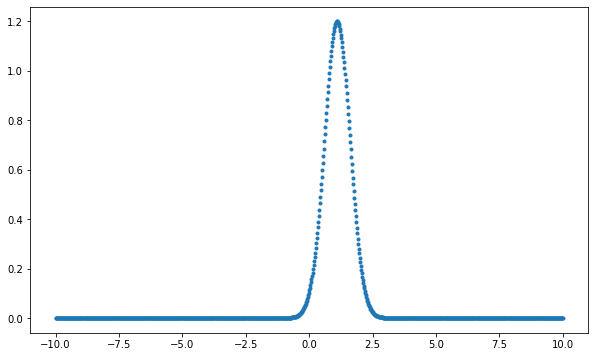

In [14]:
plt.plot(x, g(x), '.')

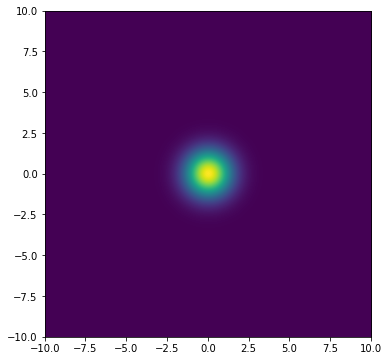

In [16]:
X, Y = np.meshgrid(x, y)
plt.imshow(g2(X, Y), extent=[-10, 10, -10, 10])

## Fitting 1D data

Above, we saw how to initialize models and use them as parametrized functions. In some cases, you may want to fit these models to data - for this you can use the astropy.modeling.fitting sub-package:

In [17]:
from astropy.modeling import fitting

We can set up fake data to fit for now:

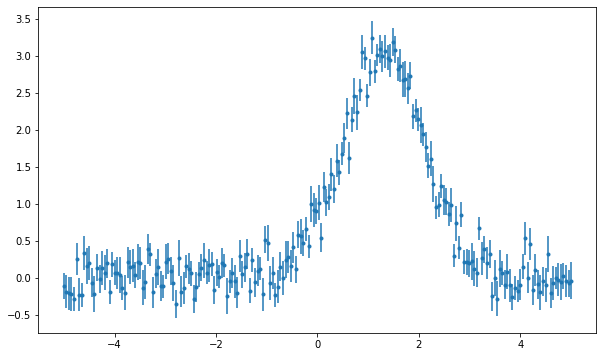

In [18]:
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
yerr = np.random.uniform(0.15, 0.25, x.shape)
_ = plt.errorbar(x, y, yerr=yerr, fmt='.')

We start off by creating a fitter - there are a number of different fitters available, and here we will use the Levenberg-Marquardt algorithm (which is implemented by [scipy](https://www.scipy.org/) behind the scenes):

In [19]:
fitter = fitting.LevMarLSQFitter()

We set up an initial model to fit to the data:

In [23]:
g_init = models.Gaussian1D()
g_init

<Gaussian1D(amplitude=1., mean=0., stddev=1.)>

and fitting consists of calling the fitter with the initial model and the data:

In [24]:
g_fit = fitter(g_init, x, y)
g_fit

<Gaussian1D(amplitude=3.05223206, mean=1.30544911, stddev=0.79370383)>

or taking errors into account:

In [25]:
g_fit_witherr = fitter(g_init, x, y, weights=1/yerr)
g_fit_witherr

<Gaussian1D(amplitude=3.04336615, mean=1.30715059, stddev=0.78767112)>

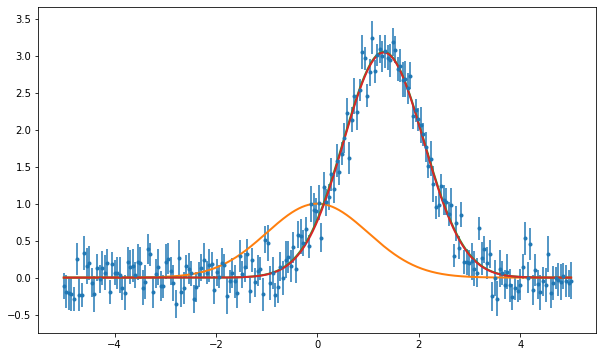

In [31]:
plt.errorbar(x, y, yerr=yerr, fmt='.')
xfine = np.linspace(-5, 5, 1000)
plt.plot(xfine, g_init(xfine), lw=2)
plt.plot(xfine, g_fit(xfine), lw=2)
plt.plot(xfine, g_fit_witherr(xfine), lw=2)

Note that this fitter instance should have an attribute ``fitter.fit_info`` which contains information about the fit. Whether this kind of attribute is available or not depends on the fitter you are using, so be sure to check the documentation for each fitter:

In [33]:
fitter.fit_info['param_cov']

array([[ 1.87804540e-03,  1.86465241e-05, -3.26045156e-04],
       [ 1.86465241e-05,  1.68005117e-04, -1.02761346e-05],
       [-3.26045156e-04, -1.02761346e-05,  1.68908089e-04]])


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<p>Try fitting a Lorentzian and a Trapezoidal model to the same data. You can use tab-completion to find these models, or search in the <a href="http://docs.astropy.org/en/stable/modeling/index.html">documentation page</a>. Overplot these models on the data along with the Gaussian fit.</p>

</div>

</section>


## Fitting 2D data

Fitting 2D data is similar to fitting 1D data, except that the inputs to the fitting need to be two-dimensional arrays. To demonstrate this we start off by generating a fake 2D dataset:

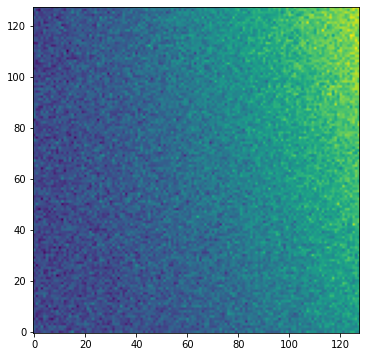

In [34]:
y2, x2 = np.mgrid[:128, :128]
z2 = 2. * x2 ** 2 - 0.5 * x2 ** 2 + 1.5 * x2 * y2 - 1.
z2 += np.random.normal(0., 0.1, z2.shape) * 50000.
plt.imshow(z2)

We now set up a 2D polynomial model:

In [35]:
p_init = models.Polynomial2D(degree=2)
p_init

<Polynomial2D(2, c0_0=0., c1_0=0., c2_0=0., c0_1=0., c0_2=0., c1_1=0.)>

and fit it in a similar way to before:

In [37]:
p_fit = fitter(p_init, x2, y2, z2)

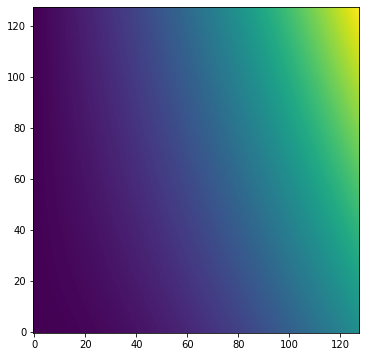

In [38]:
plt.imshow(p_fit(x2, y2))

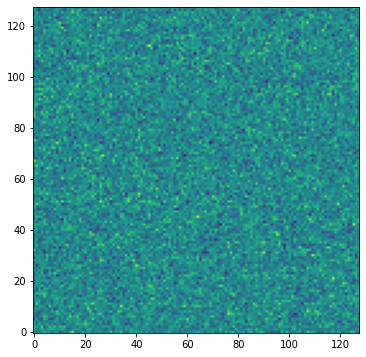

In [39]:
plt.imshow(z2-p_fit(x2, y2))


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<p>Read in the GAIA source density FITS file we used in previous tutorials, and try fitting a 2D Gaussian to it.</p>

</div>

</section>


## Compound models

In real-life cases, models such as simple Gaussians may be too simple, and you may need to fit combinations of models to data. To illustrate how to do this, we modify the simulated data we set up before:

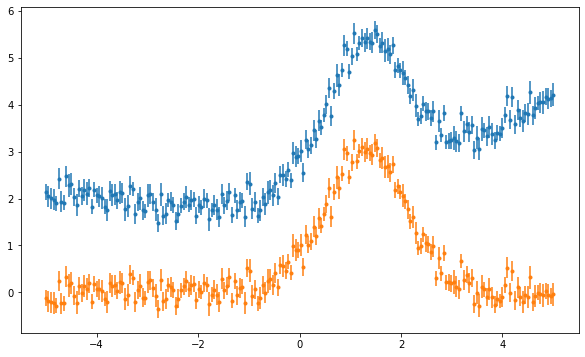

In [43]:
y_mod = y + 0.05 * x**2 +0.2 * x + 2
_ = plt.errorbar(x, y_mod, yerr=yerr, fmt='.')
_ = plt.errorbar(x, y, yerr=yerr, fmt='.')

To fit this, we set up a compound model which is the sum of two model *instances*:

In [47]:
combined_init = models.Gaussian1D() + models.Polynomial1D(degree=2)
combined_init


<CompoundModel(amplitude_0=1., mean_0=0., stddev_0=1., c0_1=0., c1_1=0., c2_1=0.)>

and we fit it as before:

In [50]:
combined_fit = fitter(combined_init, x, y_mod, weights=1/yerr)
combined_fit

<CompoundModel(amplitude_0=2.98893755, mean_0=1.3156788, stddev_0=0.76813888, c0_1=2.0782781, c1_1=0.19955582, c2_1=0.0447886)>

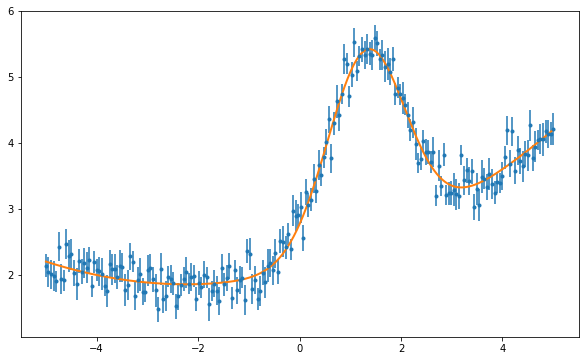

In [51]:
plt.errorbar(x, y_mod, yerr=yerr, fmt='.')
plt.plot(xfine, combined_fit(xfine), lw=2)

Note that the parameter names of a compound model include numerical suffixes to indicate which model they belong to:

In [52]:
combined_fit

<CompoundModel(amplitude_0=2.98893755, mean_0=1.3156788, stddev_0=0.76813888, c0_1=2.0782781, c1_1=0.19955582, c2_1=0.0447886)>

In [53]:
combined_fit.mean_0

Parameter('mean', value=1.3156787950989417)

It is also possible to get the individual models back, with the final parameters set:

In [54]:
combined_fit[0]

<Gaussian1D(amplitude=2.98893755, mean=1.3156788, stddev=0.76813888)>

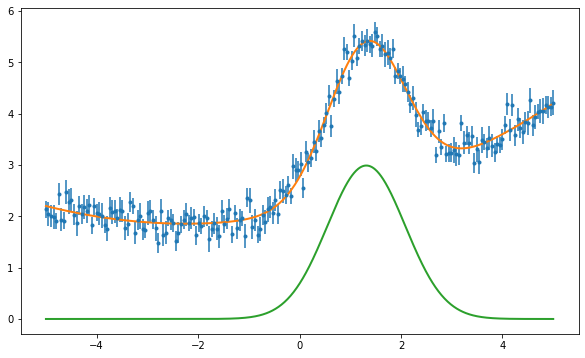

In [55]:
plt.errorbar(x, y_mod, yerr=yerr, fmt='.')
plt.plot(xfine, combined_fit(xfine), lw=2)
plt.plot(xfine, combined_fit[0](xfine), lw=2)


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<ol>
<li>Modify the plot of the combined fit to show the individual model components for the best-fit parameters.</li>
<li>Continue the previous challenge to fit the LMC source density map by fitting two Gaussians to it. Be aware that especially with compound models, initial values matter! [advanced]</li>
</ol>

</div>

</section>


## Working with units and quantities

Most models can work with unitful quantities. For example, we can create a Gaussian model with physical units for the input and output values:

In [56]:
from astropy import units as u

In [57]:
g_unitful = models.Gaussian1D(amplitude=4 * u.mJy, mean=3*u.micron, stddev=0.5*u.micron)
g_unitful

<Gaussian1D(amplitude=4. mJy, mean=3. micron, stddev=0.5 micron)>

In [60]:
g_unitful(0.0002 * u.mm)

<Quantity 6.19901254e-07 mJy>

In [62]:
g_unitful(150 * u.THz, equivalencies={'x': u.spectral()})

<Quantity 0.53835132 mJy>

In [63]:
x_unitful = x * u.micron
y_unitful = y * u.Jy
g_unitful_fit = fitter(g_unitful, x_unitful, y_unitful)
g_unitful_fit

<Gaussian1D(amplitude=3.05222978 Jy, mean=1.30544831 micron, stddev=0.79370502 micron)>

## Additional functionality

The astropy.modeling sub-package contains a lot more functionality, including:

* Defining your own models
* Fixing or tiying parameters
* Using custom statistics

See the [documentation](http://docs.astropy.org/en/stable/modeling/index.html) for more!

<center><i>This notebook was originally written by <a href="https://aperiosoftware.com/">Aperio Software Ltd</a> and modified by Brigitta Sipőcz. &copy; 2019-2021 and is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License (CC BY 4.0)</a></i></center>

![cc](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)